In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

import sys
sys.path.append('..')

from datetime import datetime

import numpy as np
import pandas as pd

import brasa

In [21]:
symbols = [
    "ABEV3",
    "ARZZ3",
    "B3SA3",
    "BBAS3",
    "EGIE3",
    "EZTC3",
    "INTB3",
    "ITSA4",
    "PSSA3",
    "WEGE3",
]

rets = brasa.get_returns(symbols=symbols, start=datetime(2023, 1, 1), end=datetime.today())

In [22]:
rets.sum().sort_values()

INTB3   -0.321895
ARZZ3   -0.134196
WEGE3   -0.036839
ABEV3   -0.013886
B3SA3    0.121129
EGIE3    0.228853
PSSA3    0.253270
ITSA4    0.291951
EZTC3    0.336659
BBAS3    0.534790
dtype: float64

In [29]:
weights = pd.Series([
    9.58/100,
    10.75/100,
    7.80/100,
    11.71/100,
    19.17/100,
    8.00/100,
    5.84/100,
    9.55/100,
    15.62/100,
    1.96/100,
], index=symbols)
weights

ABEV3    0.0958
ARZZ3    0.1075
B3SA3    0.0780
BBAS3    0.1171
EGIE3    0.1917
EZTC3    0.0800
INTB3    0.0584
ITSA4    0.0955
PSSA3    0.1562
WEGE3    0.0196
dtype: float64

In [38]:
brasa.get_dataset("b3-indexes-returns").scanner(columns=["symbol"]).to_table().to_pandas().drop_duplicates()["symbol"].sort_values()

36124    AGFS
16       BDRX
33782    GPTW
19       IBOV
4        IBRA
45496    IBSD
15       IBXL
2        IBXX
23       ICO2
3        ICON
9        IDIV
45764    IDVR
18       IEEX
28393    IFIL
0        IFIX
11       IFNC
8        IGCT
12       IGCX
13       IGNM
22       IMAT
17       IMOB
5        INDX
10       ISEE
7        ITAG
1        IVBX
20       MLCX
6        SMLL
14       TFIX
21       UTIL
Name: symbol, dtype: object

In [56]:
brasa.get_returns(symbols=["IBOV", "AGFS", "IFNC", "ICON", "ICO2", "IEEX", "IFIX", "IFIL", "IMAT", "IDIV", "SMLL", "MLCX", "IMOB", "UTIL", "IVBX", "INDX"],
                  start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values()

ICON    0.061098
IMAT    0.062383
AGFS    0.111633
INDX    0.116206
IFIL    0.125661
IFIX    0.125796
IVBX    0.152287
SMLL    0.154805
IEEX    0.170402
UTIL    0.182033
MLCX    0.190347
IBOV    0.191880
ICO2    0.213763
IDIV    0.222713
IFNC    0.281535
IMOB    0.407469
dtype: float64

In [28]:
brasa.get_returns(symbols=["HASH11", "QBTC11"], start=datetime(2023, 1, 1), end=datetime.today()).sum()

HASH11    0.767638
QBTC11    0.927466
dtype: float64

<Axes: >

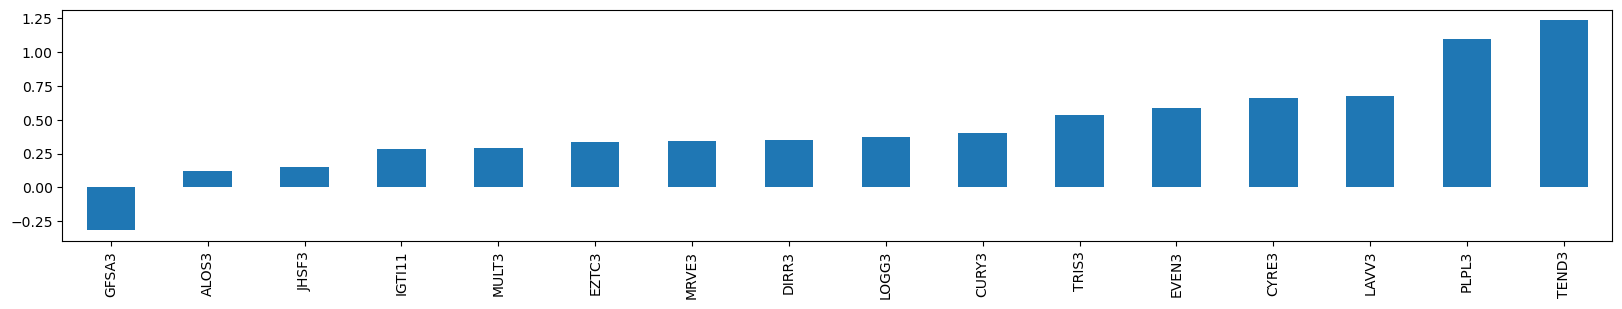

In [69]:
import pyarrow.compute as pc

imob_symbols = brasa.get_dataset("b3-indexes-composition").filter(pc.field("indexes") == "IMOB").to_table().to_pandas()["code"]
brasa.get_returns(symbols=imob_symbols, start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values().plot(kind="bar", figsize=(20, 3))

<Axes: >

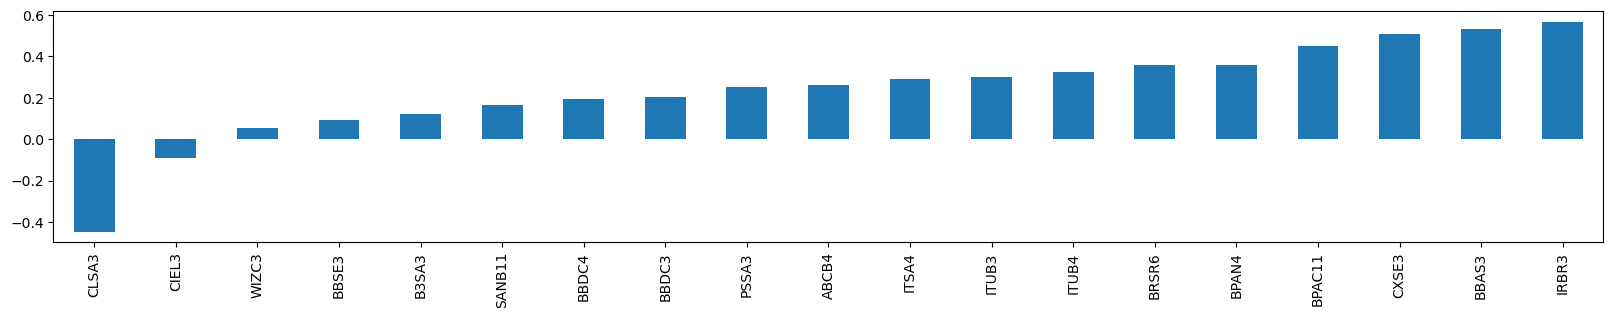

In [70]:
import pyarrow.compute as pc

imob_symbols = brasa.get_dataset("b3-indexes-composition").filter(pc.field("indexes") == "IFNC").to_table().to_pandas()["code"]
brasa.get_returns(symbols=imob_symbols, start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values().plot(kind="bar", figsize=(20, 3))

<Axes: >

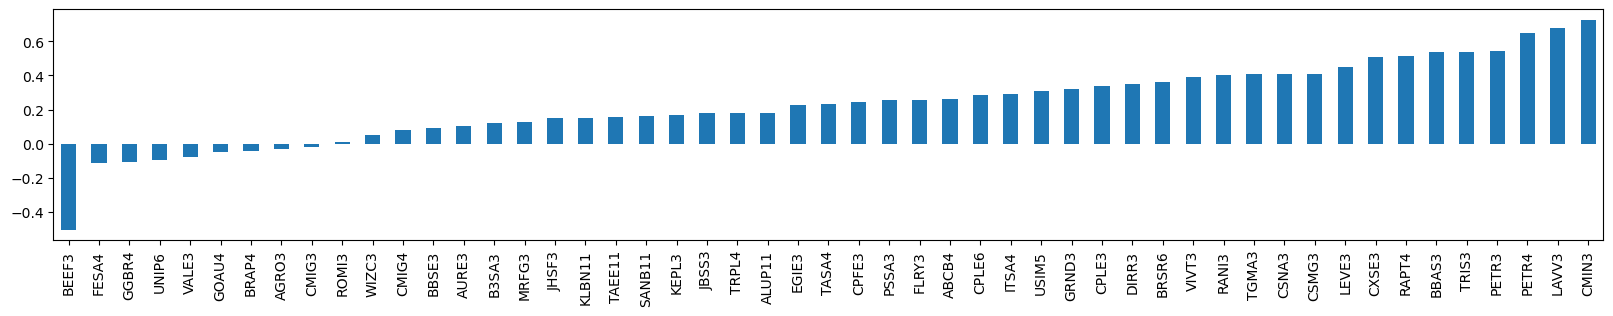

In [71]:
import pyarrow.compute as pc

imob_symbols = brasa.get_dataset("b3-indexes-composition").filter(pc.field("indexes") == "IDIV").to_table().to_pandas()["code"]
brasa.get_returns(symbols=imob_symbols, start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values().plot(kind="bar", figsize=(20, 3))

<Axes: >

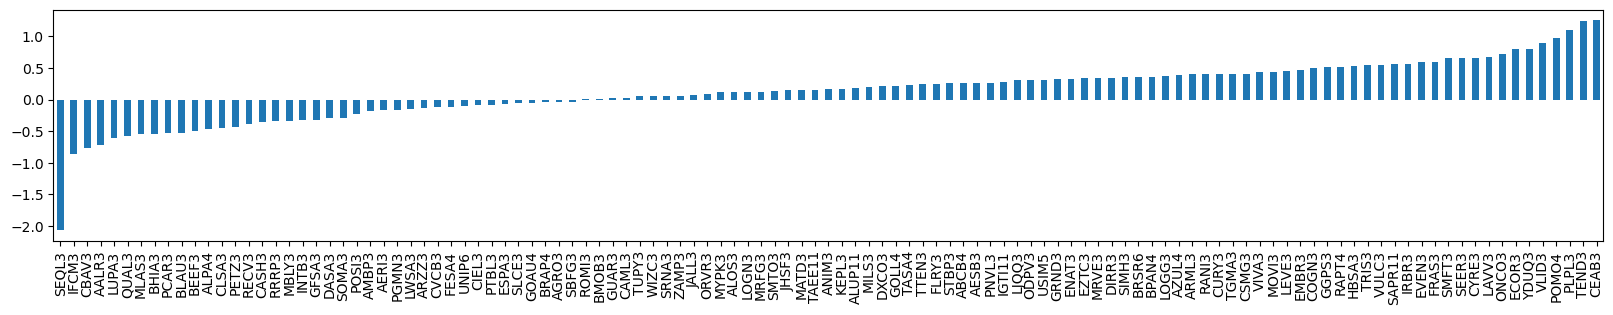

In [72]:
import pyarrow.compute as pc

imob_symbols = brasa.get_dataset("b3-indexes-composition").filter(pc.field("indexes") == "SMLL").to_table().to_pandas()["code"]
brasa.get_returns(symbols=imob_symbols, start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values().plot(kind="bar", figsize=(20, 3))